## Loading data and image segmentation

In this lab, we'll work with hyperspectral imaging data. We'll start by loading the data and visualizing it in both grayscale and an RGB-like format to get an initial sense of what we're working with.

Next, we'll use the Segment Anything framework to segment the image and generate masks. We'll then filter these masks by size and remove any overlapping regions to clean up our segmentation results.

After that, we'll extract and plot the spectral signatures of each remaining mask. From these, we'll identify the masks that correspond to kiwi spectra and keep only those. Finally, we'll sort the selected masks and save their spectral data, which will be used as input for future labs.

Let's start by loading a .mat file using `scipy.io.loadmat` function and inspecting the object.

In [28]:
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filepath = "data/1A.mat"
mat = scipy.io.loadmat(filepath)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Wavelength', 'img'])

The fields such as `__header__`, `__version__`, `__globals__` are automatically generated by Matlab. Let's inspect the contents of fields `Wavelength` and `img`

In [29]:
mat["Wavelength"]

array([[ 398.86],
       [ 401.4 ],
       [ 403.95],
       [ 406.5 ],
       [ 409.05],
       [ 411.61],
       [ 414.16],
       [ 416.73],
       [ 419.29],
       [ 421.86],
       [ 424.43],
       [ 427.  ],
       [ 429.57],
       [ 432.15],
       [ 434.73],
       [ 437.31],
       [ 439.9 ],
       [ 442.49],
       [ 445.08],
       [ 447.67],
       [ 450.27],
       [ 452.86],
       [ 455.46],
       [ 458.07],
       [ 460.67],
       [ 463.28],
       [ 465.89],
       [ 468.5 ],
       [ 471.12],
       [ 473.73],
       [ 476.35],
       [ 478.97],
       [ 481.59],
       [ 484.22],
       [ 486.84],
       [ 489.47],
       [ 492.1 ],
       [ 494.74],
       [ 497.37],
       [ 500.01],
       [ 502.65],
       [ 505.29],
       [ 507.93],
       [ 510.58],
       [ 513.22],
       [ 515.87],
       [ 518.52],
       [ 521.17],
       [ 523.82],
       [ 526.48],
       [ 529.13],
       [ 531.79],
       [ 534.45],
       [ 537.11],
       [ 539.78],
       [ 5

In [30]:
mat["Wavelength"].shape

(224, 1)

As we can see the field `Wavelength` contains an array with values of wavelenths at which the hyperspectral image was obtained. There are 224 unique wavelengths, ranging from 398.86 till 1002.2

Next let's inspect the`img` part:

In [31]:
mat["img"].shape

(930, 1024, 224)

Our image is 930 pixels by 1024. Each pixel has it's intensity values recorded at 224 distinct wavelengths. Let's visualize how it looks like at one of the wavelengths

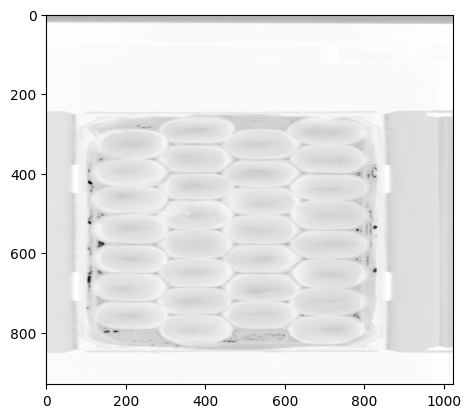

In [32]:
fig = plt.figure()
plt.imshow(mat["img"][:,:,150], cmap='Greys')

Let's construct a pseudo-RGB image out of this hyperspectral image. In order to do so we need to combine 3 images at wavelengths roughly corresponding to red (around 600 nm), green (around 550 nm), and blue (around 450 nm).  
or 445, 535, 575?

In [33]:
print(mat["Wavelength"][18], mat["Wavelength"][52], mat["Wavelength"][67])

[445.08] [534.45] [574.53]


In [34]:
red = 575
green = 535
blue = 445

def find_closest_index(target, array):
    array = np.asarray(array)
    idx = np.abs(array - target).argmin()
    return idx

def create_pseudo_rgb_image(hyperspectral_image, wavelengths):
    r_index = find_closest_index(red,wavelengths)
    g_index = find_closest_index(green,wavelengths)
    b_index = find_closest_index(blue,wavelengths)
    rgb_img = np.stack([
        hyperspectral_image[:, :, r_index],
        hyperspectral_image[:, :, g_index],
        hyperspectral_image[:, :, b_index]
    ], axis=-1)


    # TODO explain why we need to normalize, why can there be negative values?
    # Initialize normalized image
    norm_img = np.empty_like(rgb_img, dtype=np.float32)

    # Normalize each channel independently
    for i in range(3):
        channel = rgb_img[:, :, i]
        vmin = np.percentile(channel, 1)
        vmax = np.percentile(channel, 99)
        norm_img[:, :, i] = np.clip((channel - vmin) / (vmax - vmin), 0, 1)

    # Convert to uint8
    rgb_uint8 = (norm_img * 255).astype(np.uint8)
    return rgb_uint8

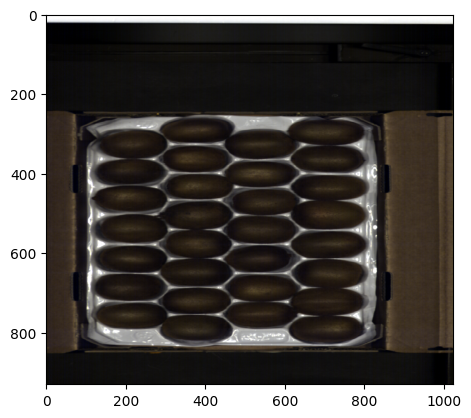

In [35]:
rgb_img = create_pseudo_rgb_image(mat["img"], mat["Wavelength"])
fig = plt.figure()
plt.imshow(rgb_img)

In [36]:
hyperspectral_img = mat["img"]
wavelengths = mat["Wavelength"]

# Segmentation and object detection

## Deep learning segmentation

In order to analyze just the spectra related to kiwi fruits we need to segment the image first. There are various ways to do it, but the easiest and perhaps most accessible is to use deep learning models. In the next section we will segment the image using Segment Anything framework. The code below works fastest if you have a GPU.

In [37]:
# Let's check if your machine has an access to GPU
!nvidia-smi

Wed Jun  4 11:34:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.106                Driver Version: 552.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500 Laptop GPU    On  |   00000000:01:00.0  On |                  Off |
| N/A   46C    P8             20W /  115W |    7684MiB /  16384MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import supervision as sv

def detect_with_sam(rgb_img):
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"DEVICE = {DEVICE}")

    MODEL_TYPE = "vit_h"
    SAM_SAM_CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"

    sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)
    mask_generator = SamAutomaticMaskGenerator(sam)
    sam_result = mask_generator.generate(rgb_img)
    return sv.Detections.from_sam(sam_result=sam_result)

sam_detections = detect_with_sam(rgb_img)

DEVICE = cuda:0


Let's visualize the results of the segmentation

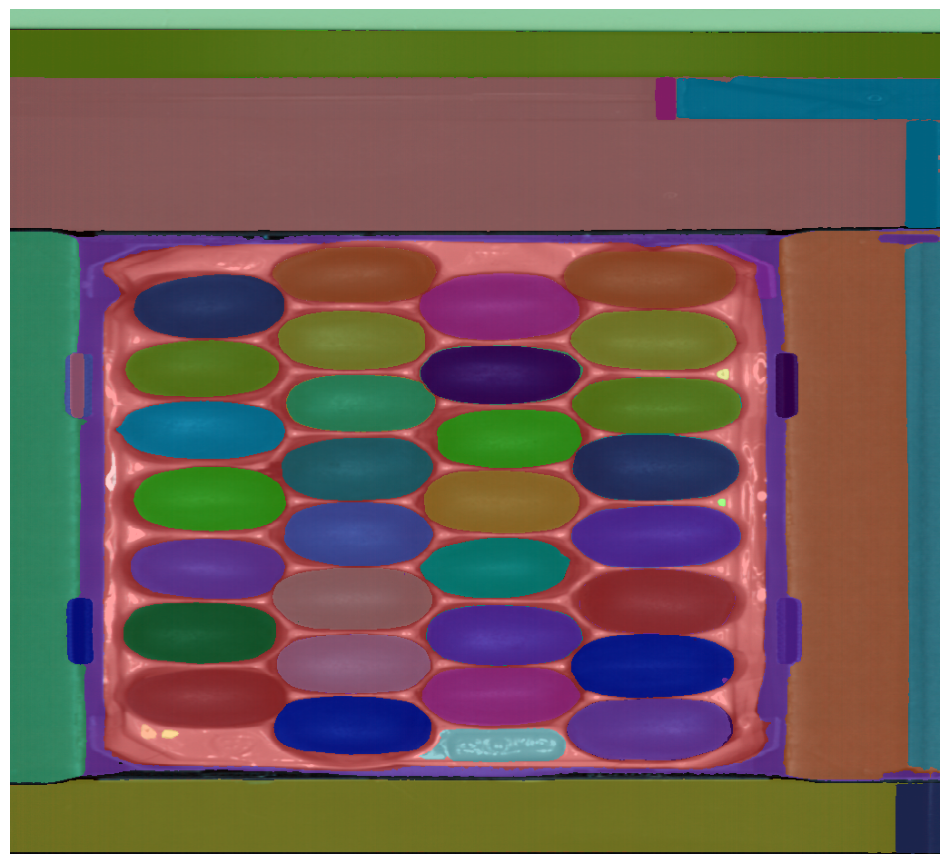

In [39]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
sam_result = mask_annotator.annotate(scene=rgb_img.copy(), detections=sam_detections)
sv.plot_image(image=sam_result)

You can see that while SAM did an incredible job segmenting the image, the tasks of choosing masks belonging to kiwi is not a trivial one. You can notice that there are overlapping masks and some masks don't represent the objects in the image, but are for example shadows. 

Let's try to see if we can achieve our goal of selecting just the kiwi masks by restricting the size of masks and only choosing non-overlapping masks

In [40]:
min_height = 40
max_height = 100
min_width = 150
max_width = 200

def make_sv_detections(masks, xyxy):
    return sv.Detections(xyxy=np.array(xyxy), mask=np.stack(masks))

def filter_masks_by_size(detections):
    filtered_masks = []
    filtered_xyxy = []
    for detection in detections:
        mask = detection[1]
        xyxy = detection[0]
        y_coords, x_coords = np.where(mask)
        height = y_coords.max() - y_coords.min() + 1
        width = x_coords.max() - x_coords.min() + 1

        if min_height <= height <= max_height and min_width <= width <= max_width:
            filtered_masks.append(mask)
            filtered_xyxy.append(xyxy) 
    return make_sv_detections(filtered_masks, filtered_xyxy)

filtered_detections = filter_masks_by_size(sam_detections)


In [41]:
def remove_overlapping_masks(detections):
    occupied = np.zeros_like(detections.mask[0], dtype=bool)
    non_overlapping_masks = []
    non_overlapping_xyxy = []

    for mask, box in zip(detections.mask, detections.xyxy):
        if not np.any(mask & occupied):
            non_overlapping_masks.append(mask)
            non_overlapping_xyxy.append(box)
            occupied |= mask  # Mark this area as taken

    if not non_overlapping_masks:
        return sv.Detections(xyxy=np.empty((0, 4)), mask=np.empty((0, *detections.mask[0].shape), dtype=bool))

    filtered_xyxy = np.array(non_overlapping_xyxy)
    filtered_masks = np.stack(non_overlapping_masks)

    return sv.Detections(xyxy=filtered_xyxy, mask=filtered_masks)


filtered_detections = remove_overlapping_masks(filtered_detections)


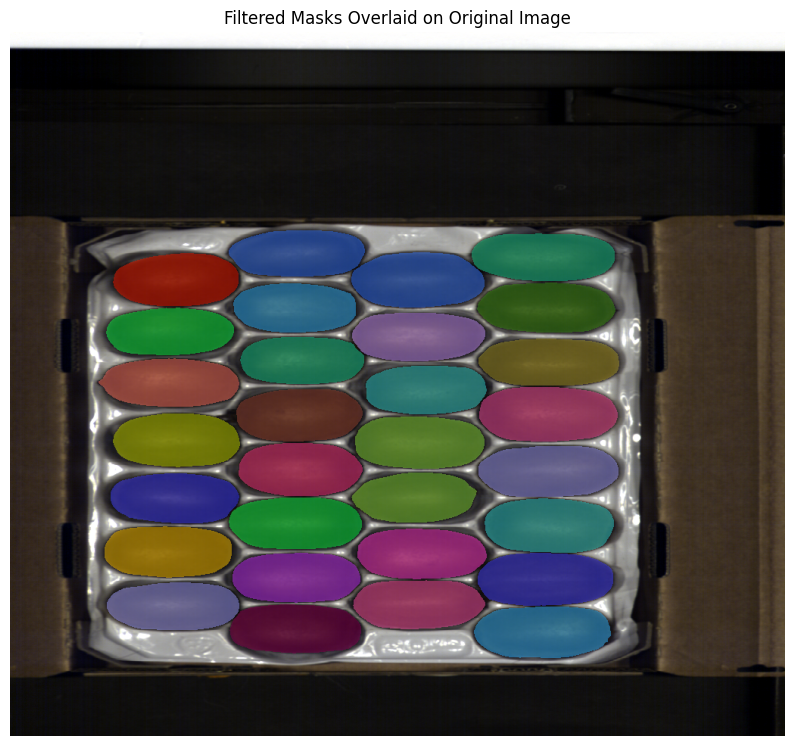

In [42]:
# Create the annotated image
annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=filtered_detections)

# Plot the original image with overlaid masks
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Filtered Masks Overlaid on Original Image")
plt.show()

DEVICE = cuda:0


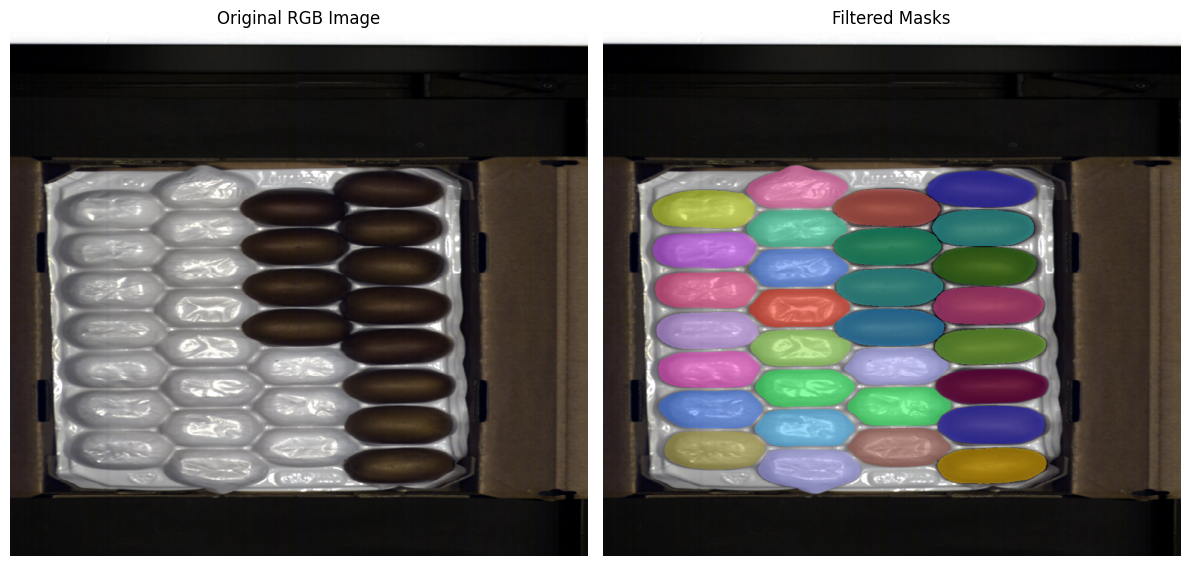

In [43]:
filepath = "data/gold_5A.mat"

# Load the .mat file
mat = scipy.io.loadmat(filepath)
hyperspectral_img = mat["img"]
wavelengths = mat["Wavelength"]

rgb_img = create_pseudo_rgb_image(hyperspectral_img, wavelengths)
new_detections = detect_with_sam(rgb_img.copy())
filtered_detections = filter_masks_by_size(new_detections)
filtered_detections = remove_overlapping_masks(filtered_detections)

# If valid masks exist, annotate and plot
if filtered_detections:
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=filtered_detections)
    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(rgb_img)
    axs[0].set_title("Original RGB Image")
    axs[0].axis("off")

    axs[1].imshow(annotated_img)
    axs[1].set_title("Filtered Masks")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

As we can see from the image above, if there are masks of similar size our approach fails. We need to use hyperspectral information in order to properly classify segmentation results. Let's begin by properly visualizing average spectrum per mask.

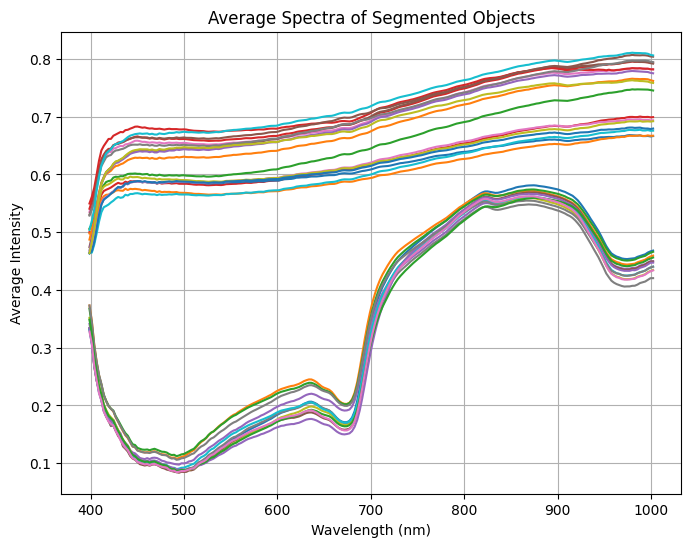

In [44]:
plt.figure(figsize=(8, 6))

for i, mask in enumerate(filtered_detections.mask):
    masked_pixels = hyperspectral_img[mask]
    avg_spectrum = masked_pixels.mean(axis=0)

    # Plot the average spectrum for this object
    plt.plot(wavelengths, avg_spectrum)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Intensity")
plt.title("Average Spectra of Segmented Objects")
plt.grid(True)
plt.show()

We can see that there are two distinct spectrum shapes. One belonging to kiwis and one to plactic tray compartments. Knowing that in that particular image the kiwi fruit are located on the right we can find a kiwi mask by sorting on x-coordinate

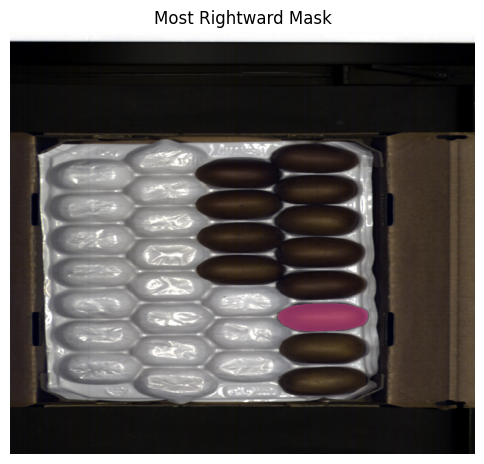

In [45]:
# Find the index with the highest x2 (right edge)
x2_values = [box[2] for box in filtered_detections.xyxy]
rightmost_index = int(np.argmax(x2_values))

rightmost_mask = filtered_detections.mask[rightmost_index]
rightmost_box = filtered_detections.xyxy[rightmost_index]

rightmost_detection = sv.Detections(
    xyxy=np.array([rightmost_box]),
    mask=np.array([rightmost_mask])
)

rightmost_annotated = mask_annotator.annotate(scene=rgb_img.copy(), detections=rightmost_detection)

plt.figure(figsize=(6, 6))
plt.imshow(rightmost_annotated)
plt.title("Most Rightward Mask")
plt.axis("off")
plt.show()

Let's find the average spectrum of pixels covered by that mask and then filter all detcted masks based on SAM (spectral angle mapper) distance. The closer distance to 0 the more similar the spectra are

In [46]:
kiwi_pixels = hyperspectral_img[rightmost_detection.mask[0]]
kiwi_avg_spectrum = kiwi_pixels.mean(axis=0)

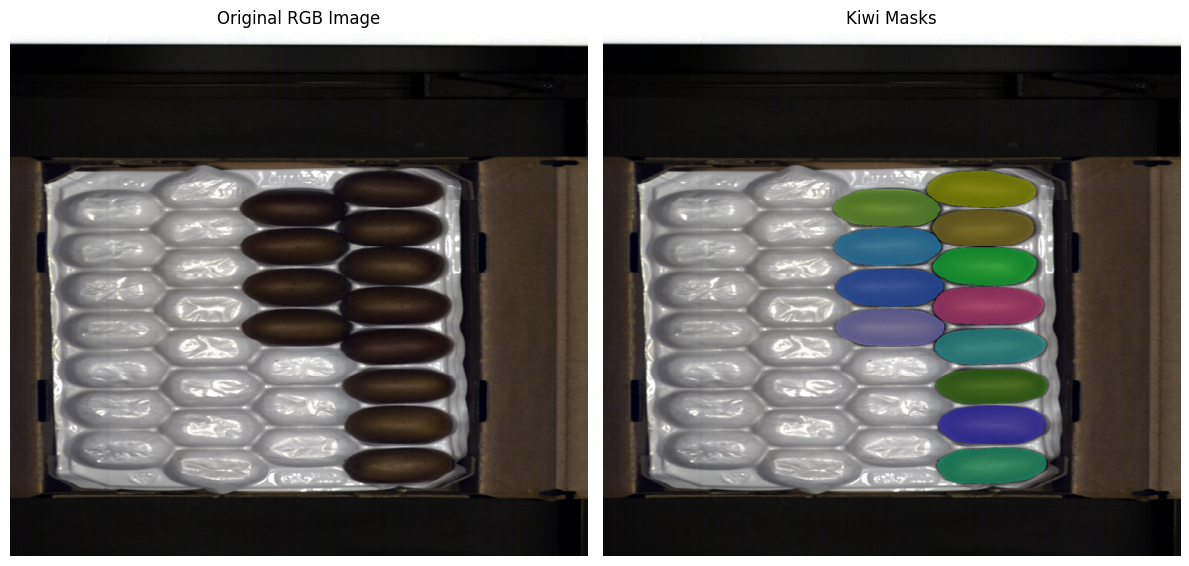

In [47]:
from pysptools.distance import SAM

def select_similar_masks(hyperspectral_img, target_spectrum, detections):
    masks = []
    xyxy = []
    for mask, box in zip(detections.mask, detections.xyxy):
        masked_pixels = hyperspectral_img[mask]
        avg_spectrum = masked_pixels.mean(axis=0)
        sam_score = SAM(target_spectrum, avg_spectrum)
        if sam_score < 0.3:
            masks.append(mask)
            xyxy.append(box)
    if masks:
        filtered_xyxy = np.array(xyxy)
        filtered_masks = np.stack(masks)

    return sv.Detections(xyxy=filtered_xyxy, mask=filtered_masks)

kiwi_detections=select_similar_masks(hyperspectral_img, kiwi_avg_spectrum, filtered_detections)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=kiwi_detections)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(rgb_img)
axs[0].set_title("Original RGB Image")
axs[0].axis("off")

axs[1].imshow(annotated_img)
axs[1].set_title("Kiwi Masks")
axs[1].axis("off")

plt.tight_layout()
plt.show()

That approach worked well for our image! As the last step we should try to save the average spectra per each kiwi. It's important that we keep track of which spectra belongs to which kiwi. In this dataset we agreed to count kiwis from right column down and to the left. Since the masks are slightly diffrent size we would need to group their x coordinates to make sure that we count columns correctly (we will use centroids to sort and DBSCAN for clustering).

In [48]:
def compute_centroids(detections):
    centroids = []
    for mask in detections.mask:
        y_coords, x_coords = np.where(mask)
        cx = np.mean(x_coords)
        cy = np.mean(y_coords)
        centroids.append((cx, cy))
    return np.array(centroids)

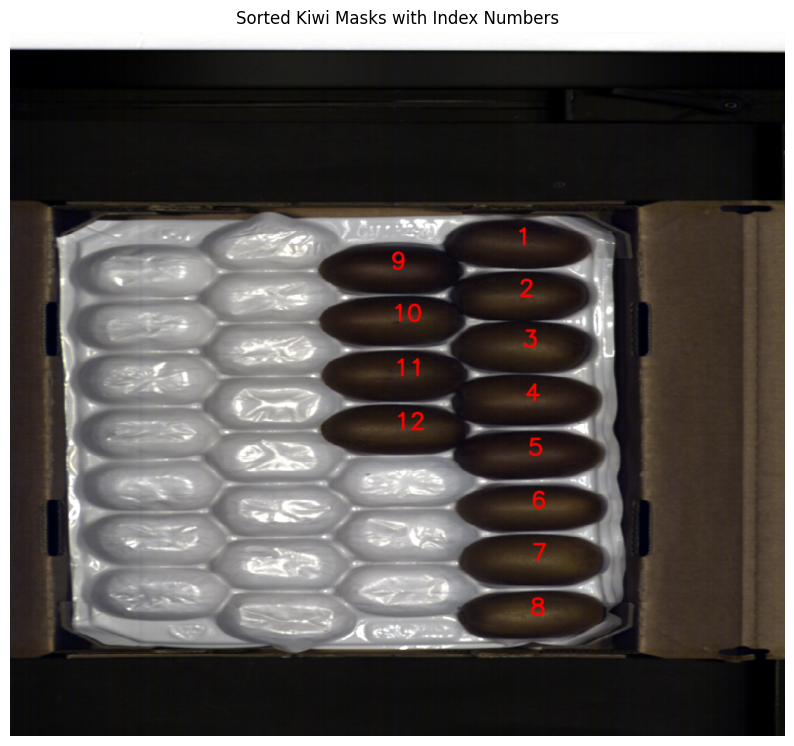

In [49]:
from sklearn.cluster import DBSCAN

def compute_centroids(detections):
    centroids = []
    for mask in detections.mask:
        y_coords, x_coords = np.where(mask)
        cx = np.mean(x_coords)
        cy = np.mean(y_coords)
        centroids.append((cx, cy))
    return np.array(centroids)

# Compute centroids
centroids = compute_centroids(kiwi_detections)

# Cluster by x-coordinate only (to group into columns)
clustering = DBSCAN(eps=50, min_samples=1).fit(centroids[:, [0]])
labels = clustering.labels_

# Group centroids and masks by cluster
clustered = {}
for label, centroid, detection in zip(labels, centroids, kiwi_detections.mask):
    clustered.setdefault(label, []).append((centroid, detection))

# Sort columns from right to left
sorted_columns = sorted(clustered.items(), key=lambda item: -np.mean([c[0][0] for c in item[1]]))

# For each column, sort top to bottom
sorted_masks = []
for _, column in sorted_columns:
    sorted_column = sorted(column, key=lambda x: x[0][1])
    sorted_masks.extend(sorted_column)

# Draw labels
labeled_img = rgb_img.copy()
for idx, (centroid, mask) in enumerate(sorted_masks):
    cx, cy = int(centroid[0]), int(centroid[1])
    cv2.putText(
        labeled_img, str(idx + 1), (cx, cy),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(255, 0, 0),
        thickness=2,
        lineType=cv2.LINE_AA
    )

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(labeled_img)
plt.title("Sorted Kiwi Masks with Index Numbers")
plt.axis("off")
plt.show()

In [50]:
from sklearn.cluster import DBSCAN

def sort_detections_by_column_then_row(detections, eps=50):
    centroids = compute_centroids(detections)

    # Cluster centroids by x-coordinate (group into columns)
    clustering = DBSCAN(eps=eps, min_samples=1).fit(centroids[:, [0]])
    labels = clustering.labels_

    # Group by cluster label
    clustered = {}
    for label, centroid, mask in zip(labels, centroids, detections.mask):
        clustered.setdefault(label, []).append((centroid, mask))

    # Sort columns right-to-left, then rows top-to-bottom
    sorted_masks = []
    for _, column in sorted(clustered.items(), key=lambda item: -np.mean([c[0][0] for c in item[1]])):
        sorted_column = sorted(column, key=lambda x: x[0][1])
        sorted_masks.extend(sorted_column)

    return sorted_masks

In [51]:
import os
import csv

def save_sorted_mask_spectra_and_image(detections, hyperspectral_img, rgb_img, output_dir, basename):
    os.makedirs(output_dir, exist_ok=True)
    spectra = []
    sorted_masks = sort_detections_by_column_then_row(detections)

    spectra_csv_path = os.path.join(output_dir, f"{basename}_average_spectra.csv")
    with open(spectra_csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Mask Index"] + [f"Band {i}" for i in range(hyperspectral_img.shape[2])])

        labeled_img = rgb_img.copy()
        for idx, (centroid, mask) in enumerate(sorted_masks):
            masked_pixels = hyperspectral_img[mask]
            avg_spectrum = masked_pixels.mean(axis=0)
            spectra.append(avg_spectrum)
            writer.writerow([idx + 1] + avg_spectrum.tolist())

            cx, cy = int(centroid[0]), int(centroid[1])
            cv2.putText(
                labeled_img, str(idx + 1), (cx, cy),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 0, 0),
                thickness=2,
                lineType=cv2.LINE_AA
            )

    img_path = os.path.join(output_dir, f"{basename}_labeled.png")
    cv2.imwrite(img_path, cv2.cvtColor(labeled_img, cv2.COLOR_RGB2BGR))
    print(f"[✓] Saved spectra to {spectra_csv_path}")
    print(f"[✓] Saved labeled image to {img_path}")
    return spectra


In [52]:
input_folder = "data"
output_folder = "results"

all_spectra = []

def save_mask_overlay(image, detections, filepath, title=None):
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_img = mask_annotator.annotate(scene=image.copy(), detections=detections)
    cv2.imwrite(filepath, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    if title:
        print(f"[✓] Saved {title} to {filepath}")

for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".mat") and "A" in filename and "gold" not in filename:
        filepath = os.path.join(input_folder, filename)
        basename = os.path.splitext(filename)[0]
        print(f"\n[→] Processing {filename}...")

        # Load data
        mat = scipy.io.loadmat(filepath)
        hyperspectral_img = mat["img"]
        wavelengths = mat["Wavelength"]

        rgb_img = create_pseudo_rgb_image(hyperspectral_img, wavelengths)
        rgb_path = os.path.join(output_folder, f"{basename}_rgb.png")
        cv2.imwrite(rgb_path, cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))

        detections = detect_with_sam(rgb_img)
        save_mask_overlay(rgb_img, detections, os.path.join(output_folder, f"{basename}_detected.png"), "Initial detections")

        filtered = filter_masks_by_size(detections)
        save_mask_overlay(rgb_img, filtered, os.path.join(output_folder, f"{basename}_filtered_size.png"), "After size filter")

        filtered = remove_overlapping_masks(filtered)
        save_mask_overlay(rgb_img, filtered, os.path.join(output_folder, f"{basename}_filtered_overlap.png"), "After overlap filter")

        kiwi_detections = select_similar_masks(hyperspectral_img, kiwi_avg_spectrum, filtered)
        if len(kiwi_detections.mask) == 0:
            print("[!] No matching masks found.")
            continue

        sorted_spectra = save_sorted_mask_spectra_and_image(
            detections=kiwi_detections,
            hyperspectral_img=hyperspectral_img,
            rgb_img=rgb_img,
            output_dir=output_folder,
            basename=basename
        )
        all_spectra.extend(sorted_spectra)


[→] Processing 1A.mat...
DEVICE = cuda:0
[✓] Saved Initial detections to results/1A_detected.png
[✓] Saved After size filter to results/1A_filtered_size.png
[✓] Saved After overlap filter to results/1A_filtered_overlap.png
[✓] Saved spectra to results/1A_average_spectra.csv
[✓] Saved labeled image to results/1A_labeled.png

[→] Processing 2A.mat...
DEVICE = cuda:0
[✓] Saved Initial detections to results/2A_detected.png
[✓] Saved After size filter to results/2A_filtered_size.png
[✓] Saved After overlap filter to results/2A_filtered_overlap.png
[✓] Saved spectra to results/2A_average_spectra.csv
[✓] Saved labeled image to results/2A_labeled.png

[→] Processing 3A.mat...
DEVICE = cuda:0
[✓] Saved Initial detections to results/3A_detected.png
[✓] Saved After size filter to results/3A_filtered_size.png
[✓] Saved After overlap filter to results/3A_filtered_overlap.png
[✓] Saved spectra to results/3A_average_spectra.csv
[✓] Saved labeled image to results/3A_labeled.png

[→] Processing 4A.mat

In [53]:
spectra_array = np.stack(all_spectra)
spectra_array.shape

(180, 224)

In [58]:
np.savetxt("results/kiwi_avg_spectra.csv", spectra_array, delimiter=",", fmt="%s")
np.savetxt("results/wavelengths.csv", wavelengths, delimiter=",", fmt="%s")

## Extra: segmenting NIR images

In [59]:
# TODO choose wavelengths outside of visible spectra and see if SAM still good at segmentation